In [1]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models

In [36]:
DATA_DIR = 'data'
BATCH_SIZE = 9
VALIDATION_SPLIT = 0.2
SEED = 0
OUTPUT_SEQUENCE_LENGTH = 16000
SUBSET = 'both'
NUM_LABELS = 5

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [16]:
def get_spectrogram(waveform):
  # Getting the spectogram
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
def data_prep():
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    seed=0,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    subset=SUBSET)

    train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
    val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

    input_shape = train_ds.take(1).shape[1:]

    test_ds = val_ds.shard(num_shards=2, index=0)
    val_ds = val_ds.shard(num_shards=2, index=1)

    train_spectrogram_ds = make_spec_ds(train_ds)
    val_spectrogram_ds = make_spec_ds(val_ds)
    test_spectrogram_ds = make_spec_ds(test_ds)

    return train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds

In [27]:
train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds = data_prep()

Found 111 files belonging to 5 classes.
Using 89 files for training.
Using 22 files for validation.


In [38]:
def training_loop():
    train_spectrogram_ds,val_spectrogram_ds,test_spectrogram_ds = data_prep()
    
    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

    for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
      break

    input_shape = example_spectrograms.shape[1:]
    
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_LABELS),
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    
    EPOCHS = 10
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

    return model,history

    



In [40]:
model,history = training_loop()

Found 111 files belonging to 5 classes.
Using 89 files for training.
Using 22 files for validation.
Epoch 1/10
10/10 [==============================] - 2s 74ms/step - loss: 1.6486 - accuracy: 0.2360 - val_loss: 1.2846 - val_accuracy: 0.4444
Epoch 2/10
10/10 [==============================] - 1s 62ms/step - loss: 1.4553 - accuracy: 0.4382 - val_loss: 1.2226 - val_accuracy: 0.5556
Epoch 3/10
10/10 [==============================] - 1s 60ms/step - loss: 1.3018 - accuracy: 0.5169 - val_loss: 1.0673 - val_accuracy: 0.5556
Epoch 4/10
10/10 [==============================] - 1s 62ms/step - loss: 1.2118 - accuracy: 0.5169 - val_loss: 1.0439 - val_accuracy: 0.7778
Epoch 5/10
10/10 [==============================] - 1s 62ms/step - loss: 1.1098 - accuracy: 0.5730 - val_loss: 0.9303 - val_accuracy: 0.6667
Epoch 6/10
10/10 [==============================] - 1s 61ms/step - loss: 1.0041 - accuracy: 0.5955 - val_loss: 1.0009 - val_accuracy: 0.6667
Epoch 7/10
10/10 [==============================] - 1s

Text(0, 0.5, 'Accuracy [%]')

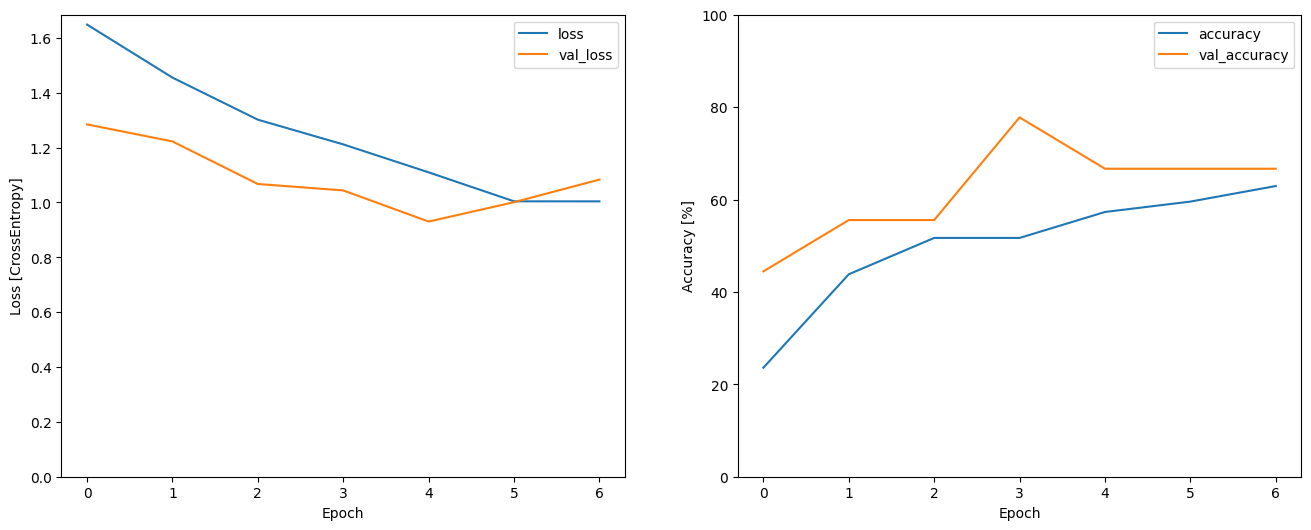

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [42]:
model.save_weights('forest_cnn_model_weights.h5')